In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib import pyplot as plt
from feat_desc import *
import cv2
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000,formatter=dict(float=lambda x: "%.3g" % x))
from corner_detector import *
from anms import *
from feat_match import *
from ransac_est_homography import *


In [4]:
# img1=cv2.imread('small-middle.jpg')
# img1=cv2.imread('mountain1.jpg')
img1 = cv2.imread('house2.jpg')
# img1=cv2.imread('case1.png')
# img1=cv2.imread('rot-middle.jpg')
gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray,None)
# print(des1.shape)

In [5]:
# img2=cv2.imread('small-right.jpg')
# img2=cv2.imread('mountain2.jpg')
img2 = cv2.imread('house1.jpg')
gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp2, des2 = sift.detectAndCompute(gray,None)

In [6]:
A = np.asarray([[1,2,3],[2,3,4],[3,4,5]])
B = np.asarray([[0,1],[0,1]])
print(A[True,True,True])
a = np.asarray([1,2,3,4,5,6])
b = np.asarray([0,0,0,1,0,1])
b = b.astype('bool')
print('----',a[b])
print(A.shape)
print(B.shape)
print(B[0,:])


[[[1 2 3]
  [2 3 4]
  [3 4 5]]]
---- [4 6]
(3, 3)
(2, 2)
[0 1]


In [7]:
xx,yy = np.meshgrid(np.arange(-5, 2,2), np.arange(-5,2,2))
x = np.array([1,2,3,2,1,2,3,2,1,2,2,4,5])
y = np.array([1,2,3,4,4,3,2,4,5,6,7,5,3])
index = np.stack((yy.flatten(), xx.flatten()), axis = -1)

In [8]:
indexRep = np.tile(index.reshape(1,-1,2),(len(x),1,1))
indexRep

array([[[-5, -5],
        [-5, -3],
        [-5, -1],
        [-5,  1],
        [-3, -5],
        [-3, -3],
        [-3, -1],
        [-3,  1],
        [-1, -5],
        [-1, -3],
        [-1, -1],
        [-1,  1],
        [ 1, -5],
        [ 1, -3],
        [ 1, -1],
        [ 1,  1]],

       [[-5, -5],
        [-5, -3],
        [-5, -1],
        [-5,  1],
        [-3, -5],
        [-3, -3],
        [-3, -1],
        [-3,  1],
        [-1, -5],
        [-1, -3],
        [-1, -1],
        [-1,  1],
        [ 1, -5],
        [ 1, -3],
        [ 1, -1],
        [ 1,  1]],

       [[-5, -5],
        [-5, -3],
        [-5, -1],
        [-5,  1],
        [-3, -5],
        [-3, -3],
        [-3, -1],
        [-3,  1],
        [-1, -5],
        [-1, -3],
        [-1, -1],
        [-1,  1],
        [ 1, -5],
        [ 1, -3],
        [ 1, -1],
        [ 1,  1]],

       [[-5, -5],
        [-5, -3],
        [-5, -1],
        [-5,  1],
        [-3, -5],
        [-3, -3],
        [-3, -1],
    

In [9]:
def findDerivatives(I_gray):
    # using the Gaussian kernel taught in class
    G = 1/159.0*np.array([[2, 4, 5, 4, 2], [4, 9, 12, 9, 4], [5, 12, 15, 12, 5], [4, 9, 12, 9, 4], [2, 4, 5, 4, 2]])

    # convolution of dx,dy with the Gaussian is equivalent to taking dx,dy with the smoothened image
    dx,dy = np.gradient(G, axis = (1,0))
    # Magx = signal.convolve2d(I_gray, dx, 'same')
    # Magy = signal.convolve2d(I_gray, dy, 'same')
    Magx = signal.convolve2d(I_gray, [[-1,0,1],[-2,0,2],[-1,0,1]], 'same')
    Magy = signal.convolve2d(I_gray, [[-1,-2,-1],[0,0,0],[1,2,1]], 'same')
    Mag = np.sqrt(Magx*Magx + Magy*Magy)

    # gives us the direction of the gradient at a pixel
    Ori = np.arctan2(Magy, Magx)
    return (Mag, Magx, Magy, Ori)

In [10]:
def feat_desc(img, x, y):
    Mag, Magx, Magy, Ori = findDerivatives(img)
    Ori = Ori+np.pi
    Ori[np.logical_and(Ori>=0,Ori<np.pi/4)] = 0
    Ori[np.logical_and(Ori>=np.pi/4,Ori<np.pi/2)]=1
    Ori[np.logical_and(Ori>=np.pi/2,Ori<3*np.pi/4)]=2
    Ori[np.logical_and(Ori>=3*np.pi/4,Ori<np.pi)]=3
    Ori[np.logical_and(Ori>=np.pi,Ori<5*np.pi/4)]=4
    Ori[np.logical_and(Ori>=5*np.pi/4,Ori<3*np.pi/2)]=5
    Ori[np.logical_and(Ori>=3*np.pi/2,Ori<7*np.pi/4)]=6
    Ori[np.logical_and(Ori>=7*np.pi/4,Ori<3*np.pi/4)]=7
    img =Ori
    descs=np.zeros((64,len(x)))
    padImage = np.zeros((img.shape[0]+40,img.shape[1]+40))
    padImage[20:img.shape[0]+20,20:img.shape[1]+20] = img
    k = 0
    for (_x,_y) in zip(x,y):
        _x = int(_x)
        _y = int(_y)
        patch = padImage[_y:_y+40,_x:_x+40]
        blurredPatch = cv2.GaussianBlur(patch,(5,5),1)
        desc = []
        for i in range(0,40,5):
            for j in range(0,40,5):
                smallPatch = patch[i:i+5,j:j+5]
                desc.append(np.where(smallPatch==0)[0].shape[0])
                desc.append(np.where(smallPatch==1)[0].shape[0])
                desc.append(np.where(smallPatch==2)[0].shape[0])
                desc.append(np.where(smallPatch==3)[0].shape[0])
                desc.append(np.where(smallPatch==4)[0].shape[0])
                desc.append(np.where(smallPatch==5)[0].shape[0])
                desc.append(np.where(smallPatch==6)[0].shape[0])
                desc.append(np.where(smallPatch==7)[0].shape[0])
                # print(maxValue)
                # print(smallPatch.shape)
        desc = np.array(desc)
        desc = (desc - desc.mean())/desc.std()
        descs[:,k]=desc
        k=k+1
    return descs

In [11]:
A = np.asarray([[1,2,3],[1,2,2],[2,3,4]])
print(2*(np.where(A==2)[0].shape[0]))
A[np.logical_and(A>=2,A<4)]=5
print(3*np.pi/4)

8
2.356194490192345


In [12]:
'''
Transformed Image Manual
'''

'\nTransformed Image Manual\n'

In [67]:
import numpy as np

def interp2(v, xq, yq):

	if len(xq.shape) == 2 or len(yq.shape) == 2:
		dim_input = 2
		q_h = xq.shape[0]
		q_w = xq.shape[1]
		xq = xq.flatten()
		yq = yq.flatten()

	h = v.shape[0]
	w = v.shape[1]
	if xq.shape != yq.shape:
		raise 'query coordinates Xq Yq should have same shape'

	x_floor = np.floor(xq).astype(np.int32)
	y_floor = np.floor(yq).astype(np.int32)
	x_ceil = np.ceil(xq).astype(np.int32)
	y_ceil = np.ceil(yq).astype(np.int32)

	x_floor[x_floor < 0] = 0
	y_floor[y_floor < 0] = 0
	x_ceil[x_ceil < 0] = 0
	y_ceil[y_ceil < 0] = 0

	x_floor[x_floor >= w-1] = w-1
	y_floor[y_floor >= h-1] = h-1
	x_ceil[x_ceil >= w-1] = w-1
	y_ceil[y_ceil >= h-1] = h-1

	v1 = v[y_floor, x_floor]
	v2 = v[y_floor, x_ceil]
	v3 = v[y_ceil, x_floor]
	v4 = v[y_ceil, x_ceil]

	lh = yq - y_floor
	lw = xq - x_floor
	hh = 1 - lh
	hw = 1 - lw

	w1 = hh * hw
	w2 = hh * lw
	w3 = lh * hw
	w4 = lh * lw

	interp_val = v1 * w1 + w2 * v2 + w3 * v3 + w4 * v4

	if dim_input == 2:
		return interp_val.reshape(q_h, q_w)
	return interp_val

In [331]:
# H = [[1.16, -0.0514, -170], [0.122, 1.11, -7.78], [0.000419, -2.5e-05, 1]]
H = [[1.33, -0.0516, -665], [0.162, 1.26, -85.6], [0.00041, -2.26e-05, 1]] #THE H MATRIX
print(np.linalg.inv(H))

[[0.62 0.0328 415]
 [-0.0971 0.79 3.01]
 [-0.000256 4.39e-06 0.83]]


-706 300 -86 680
----- -706
cornerssss [[-665 -706 300 280]
 [-86 680 33 609]
 [1 1 1 1]]
[[41 0 1.01e+03 986]
 [0 766 119 695]
 [1 1 1 1]]
-706


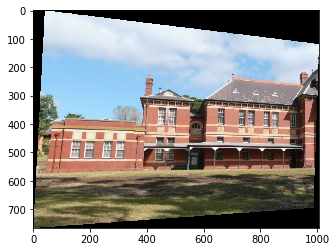

1006 -706 766 -86


In [332]:
corners = np.asarray([[0,0,1],[0,img1.shape[0],1],[img1.shape[1],0,1],[img1.shape[1],img1.shape[0],1]]).T

cornersT = np.matmul(H,corners)
cornersT = cornersT/cornersT[-1,:]
cornersT = cornersT.round()
xmax = int(np.max(cornersT[0,:]))
xmin = int(np.min(cornersT[0,:]))
ymax = int(np.max(cornersT[1,:]))
ymin = int(np.min(cornersT[1,:]))
sizex = int(xmax-xmin)
sizey = int(ymax-ymin)
print(xmin,xmax,ymin,ymax)
x_r = np.array(range(sizex))
x_r = x_r+xmin
y_r = np.array(range(sizey))
y_r = y_r+ymin

x_co1,y_co1 = np.meshgrid(x_r,y_r)
x_co = x_co1.flatten()
y_co = y_co1.flatten()
ones = np.ones(x_co.shape)
Cord = np.vstack([x_co,y_co,ones])
CordOg = np.matmul(np.linalg.inv(H),Cord)
CordOg = CordOg/CordOg[2,:]
x_og = CordOg[0,:].reshape(x_co1.shape)
y_og = CordOg[1,:].reshape(y_co1.shape)
# print(x_og.min())
im1BT = interp2(img1[:,:,0],x_og,y_og)
im1GT = interp2(img1[:,:,1],x_og,y_og)
im1RT = interp2(img1[:,:,2],x_og,y_og)

outliersX1 = np.argwhere(x_og>img1.shape[1])
outliersX2 = np.argwhere(x_og<0)
outliersY1 = np.argwhere(y_og>img1.shape[0])
outliersY2 = np.argwhere(y_og<0)
outliers = np.vstack([outliersX1,outliersX2,outliersY1,outliersY2])
im1BT[outliers[:,0],outliers[:,1]]=0
im1GT[outliers[:,0],outliers[:,1]]=0
im1RT[outliers[:,0],outliers[:,1]]=0
# print('-------',outliers[:,1].max())
print('-----',xmin)
cornersT2 = cornersT.copy()
print('cornerssss',cornersT)
cornersT2[0,:] = cornersT[0,:]-xmin
cornersT2[1,:] = cornersT[1,:]-ymin
print(cornersT2)
print(xmin)
img1T = np.zeros([sizey,sizex,3])
img1T[:,:,2] = im1BT
img1T[:,:,1] = im1GT
img1T[:,:,0] = im1RT
# print('image values', img1T[48-5,473-5,:])
# print(x_og.shape)
# print(outliersX1.shape)
# print(outliersX1[:,1].max())
plt.imshow(img1T.astype(int))
# plt.imshow(cv2.cvtColor(img1T, cv2.COLOR_BGR2RGB))
plt.show()
print(xmax-xmin,xmin,ymax-ymin,ymin)

600
<class 'numpy.ndarray'>


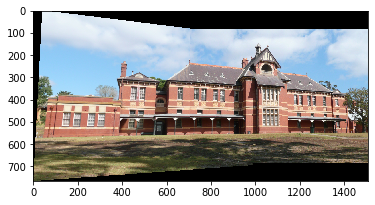

In [350]:
'''
New joined image
LEFT TO MIDDLE
'''
# print(xmax)
cxr = np.max([xmax,img2.shape[1]])
cxl = np.min([xmin,0])
cyb = np.max([ymax,img2.shape[0]])
cyt = np.min([ymin,0])
img2T = img2.copy()
# print(cxr,cxl,cyb,cyt)
sizexnew = cxr-cxl
sizeynew = cyb - cyt
imgFull = np.zeros([sizeynew,sizexnew,3])
img2RGB = img2.copy()
img2RGB[:,:,0] = img2[:,:,2]
img2RGB[:,:,2] = img2[:,:,0]
print(img2.shape[0])
# if cyt>0:
#     if xmin<0:
#         imgFull[cyt:cyt+img1T.shape[0],0:img1T.shape[1]]=img1T
#         imgFull[0:img2.shape[0],sizexnew-img2.shape[1]:sizexnew]=img2RGB
#     else:
#         imgFull[cyt:cyt+img1T.shape[0],xmin:xmin+img1T.shape[1]]=img1T
#         imgFull[0:img2.shape[0],0:img2.shape[1]]=img2RGB
# else:
#     if xmin<0:
#         imgFull[0:img1T.shape[0],0:img1T.shape[1]]=img1T
#         imgFull[-ymin:-ymin+img2.shape[0],sizexnew-img2.shape[1]:sizexnew] = img2RGB
imgFull[abs(min(0,-ymin)):abs(min(0,-ymin))+img1T.shape[0],abs(min(0,-xmin)):abs(min(0,-xmin))+img1T.shape[1]]=img1T
imgFull[max(0,-ymin):max(0,-ymin)+img2.shape[0],max(0,-xmin):max(0,-xmin)+img2.shape[1]]=img2RGB

imgFull = imgFull.astype(int)
plt.imshow(imgFull)
print(type(imgFull))
imgFull = np.asarray(imgFull,dtype = int)
# plt.imsave('housedone.jpg',imgFull)
plt.show()

In [319]:
# print(img1T.shape)
# print(x_co1)
# np.argwhere(img1T[0,:,:]>img1.shap)
A = np.asarray([[1,2,3],[2,3,4],[3,4,5]])
img1T[x_r.min()-1,y_r.max()+1,:]
A = np.pad(A,[(2,3),(1,4)],mode = 'constant')
print(abs(-1))

1
